# SVM model

In [4]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import numpy as np
import random
import imageio
import PIL, cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image, ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import seaborn as sns
from sklearn.metrics import roc_curve, auc

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14000\2593690578.py:24: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [5]:
# Function to extract labels from image filenames
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    print(subject_id, etc)
    print("filename: ", filename)
    
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')
    
    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1
    
    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4
     
    return np.array([finger], dtype=np.uint16)

In [6]:
IMG_SIZE = 96

def load_data(path, train):
    print("loading data from: ", path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    return data

In [7]:

Real_path = r"D:\PRpro\SOCOFing\Real"
Easy_path = r"D:\PRpro\SOCOFing\Altered\Altered-Easy"
Medium_path = r"D:\PRpro\SOCOFing\Altered\Altered-Medium"
Hard_path = r"D:\PRpro\SOCOFing\Altered\Altered-Hard"

In [8]:
easy_data = load_data(Easy_path, train=True)
medium_data = load_data(Medium_path, train=True)
hard_data = load_data(Hard_path, train=True)
test = load_data(Real_path, train=False)

loading data from:  D:\PRpro\SOCOFing\Altered\Altered-Easy
100 M_Left_index_finger_CR
filename:  100__M_Left_index_finger_CR
100 M_Left_index_finger_Obl
filename:  100__M_Left_index_finger_Obl
100 M_Left_index_finger_Zcut
filename:  100__M_Left_index_finger_Zcut
100 M_Left_little_finger_CR
filename:  100__M_Left_little_finger_CR
100 M_Left_little_finger_Obl
filename:  100__M_Left_little_finger_Obl
100 M_Left_little_finger_Zcut
filename:  100__M_Left_little_finger_Zcut
100 M_Left_middle_finger_CR
filename:  100__M_Left_middle_finger_CR
100 M_Left_middle_finger_Obl
filename:  100__M_Left_middle_finger_Obl
100 M_Left_middle_finger_Zcut
filename:  100__M_Left_middle_finger_Zcut
100 M_Left_ring_finger_CR
filename:  100__M_Left_ring_finger_CR
100 M_Left_ring_finger_Obl
filename:  100__M_Left_ring_finger_Obl
100 M_Left_ring_finger_Zcut
filename:  100__M_Left_ring_finger_Zcut
100 M_Left_thumb_finger_CR
filename:  100__M_Left_thumb_finger_CR
100 M_Left_thumb_finger_Obl
filename:  100__M_Left_th

In [9]:
import random

# Shuffle each dataset individually
random.shuffle(easy_data)
random.shuffle(medium_data)
random.shuffle(hard_data)

# Combine all datasets 
data = easy_data + medium_data + hard_data

# Shuffle the combined dataset
random.shuffle(data)


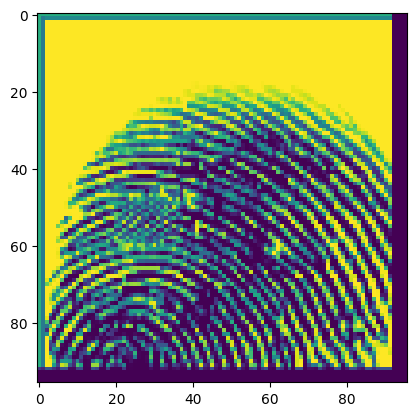

In [10]:
import matplotlib.pyplot as plt

plt.imshow(easy_data[0][1])

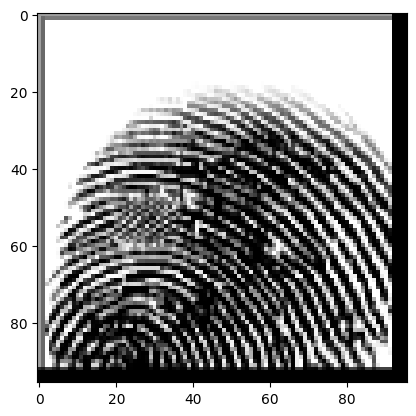

In [11]:
# display gray scale 
plt.imshow(easy_data[0][1], cmap='gray')


In [12]:
def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;
    
    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))         
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [13]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block);
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
        return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1 
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));
        
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

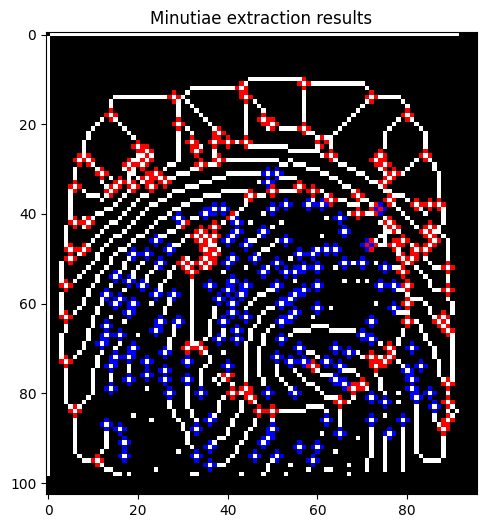

In [14]:
img_name = r"D:\PRpro\SOCOFing\Altered\Altered-Medium\1__M_Left_index_finger_CR.BMP"

img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
THRESHOLD1 = img.mean() 
img = np.array(img > THRESHOLD1).astype(int)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255;
mask = img*255;

(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask);
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=1);
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1);
ShowResults(skel, TermLabel, BifLabel)

In [33]:
X, y = [], []
for label, feature in data:
    y.append(label)
    X.append(feature)

# Reshape the input features
X_train_flat = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_train_flat = X_train_flat / 255

y_train = np.array(y)

In [34]:
# Before splitting, check the shapes of X_train_flat and y_train
print("Shapes before splitting:")
print("X_train_flat shape:", X_train_flat.shape)
print("y_train shape:", y_train.shape)

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_train_flat, y_train, test_size=0.2, random_state=42)

# After splitting, verify the shapes of the training and testing sets
print("\nShapes after splitting:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Flatten the input data to two dimensions
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Check the shape after flattening
print("X_train_flattened shape:", X_train_flattened.shape)
print("X_test_flattened shape:", X_test_flattened.shape)

# Step 3: Define and Train SVM Model
svm_model = SVC(kernel='linear', C=1.0)  # You can adjust kernel and C as needed
svm_model.fit(X_train_flattened, y_train)

# Step 4: Evaluate Model
y_pred = svm_model.predict(X_test_flattened)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Shapes before splitting:
X_train_flat shape: (49270, 96, 96, 1)
y_train shape: (49270,)

Shapes after splitting:
X_train shape: (39416, 96, 96, 1)
X_test shape: (9854, 96, 96, 1)
y_train shape: (39416,)
y_test shape: (9854,)
X_train_flattened shape: (39416, 9216)
X_test_flattened shape: (9854, 9216)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2012
           1       0.94      0.97      0.96      1917
           2       0.96      0.95      0.95      1943
           3       0.96      0.95      0.96      1985
           4       0.97      0.96      0.97      1997

    accuracy                           0.96      9854
   macro avg       0.96      0.96      0.96      9854
weighted avg       0.96      0.96      0.96      9854

Confusion Matrix:
[[1988    9    5    7    3]
 [   9 1856   17   14   21]
 [  20   40 1839   31   13]
 [  14   40   26 1889   16]
 [   9   24   24   21 1919]]


In [35]:
import joblib

# Save the trained model to a file
model_filename = 'svm_model.pkl'
joblib.dump(svm_model, model_filename)


['svm_model.pkl']

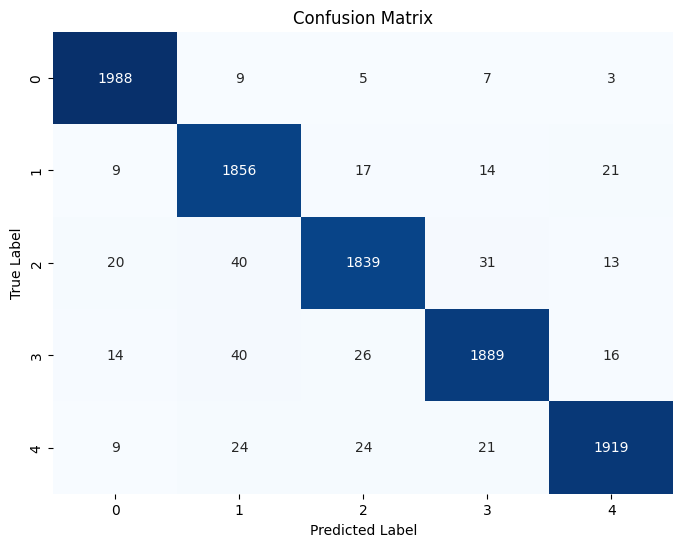

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [37]:
from sklearn.metrics import accuracy_score

# Step 4: Evaluate Model
y_pred = svm_model.predict(X_test_flattened)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print Accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 96.32%


In [39]:
import cv2
import numpy as np
import joblib

# Load your saved SVM model
svm_model = joblib.load('svm_model.pkl')

# Define the image size
IMG_SIZE = 96

# Load the image
image_path = r"D:\PRpro\SOCOFing\Real\1__M_Left_middle_finger.BMP"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image
resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
flattened_image = resized_image.flatten() / 255.0  # Flatten and normalize pixel values

# Make predictions
predicted_class = svm_model.predict([flattened_image])

print("Predicted class:", predicted_class)


Predicted class: [2]
